In [1]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [ ]:
from transformers import AutoTokenizer, BartModel, BartForConditionalGeneration, BartConfig, DataCollatorForSeq2Seq, T5ForConditionalGeneration
from datasets import load_dataset, Dataset
import evaluate
from accelerate import Accelerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-base")
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-base")


**Freeze all layers except the last one which is reponsible for sequence generation**

In [106]:
print(model.parameters)

<bound method Module.parameters of T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=

In [107]:
# freeze all layers except the last one which is used for seq generation
for param in model.parameters():
    param.requires_grad = False

for param in model.lm_head.parameters():
  param.requires_grad = True


In [108]:
for name , param in model.named_parameters(remove_duplicate=False):
    print(name, param.requires_grad)


shared.weight True
encoder.embed_tokens.weight True
encoder.block.0.layer.0.SelfAttention.q.weight False
encoder.block.0.layer.0.SelfAttention.k.weight False
encoder.block.0.layer.0.SelfAttention.v.weight False
encoder.block.0.layer.0.SelfAttention.o.weight False
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight False
encoder.block.0.layer.0.layer_norm.weight False
encoder.block.0.layer.1.DenseReluDense.wi.weight False
encoder.block.0.layer.1.DenseReluDense.wo.weight False
encoder.block.0.layer.1.layer_norm.weight False
encoder.block.1.layer.0.SelfAttention.q.weight False
encoder.block.1.layer.0.SelfAttention.k.weight False
encoder.block.1.layer.0.SelfAttention.v.weight False
encoder.block.1.layer.0.SelfAttention.o.weight False
encoder.block.1.layer.0.layer_norm.weight False
encoder.block.1.layer.1.DenseReluDense.wi.weight False
encoder.block.1.layer.1.DenseReluDense.wo.weight False
encoder.block.1.layer.1.layer_norm.weight False
encoder.block.2.layer.0.SelfAttention

**Download the dataset and start preprocssing it**


In [109]:
!wget https://huggingface.co/datasets/liweili/c4_200m/resolve/main/data.zip

In [110]:
!unzip data.zip

In [111]:
# checking number of lines

!wc -l C4_200M.tsv-00000-of-00010

In [6]:
X = []
Y = []

with open("C4_200M.tsv-00000-of-00010", "r") as f:

  for i, line in enumerate(f):
    if i == 500000:
      break

    x, y = line.split("\t")
    X.append("fix grammar: " + x)
    Y.append(y)


In [7]:
dataset  = pd.DataFrame({"X": X, "Y": Y})

The whole majority of the sequences' lengths lies between 0 and 500 words.

This will matter when deciding how much to truncate and max length of a sequence.

In [114]:
dataset.head(10)

,X,Y
0,"fix grammar: Bitcoin is for $7,094 this mornin...","Bitcoin goes for $7,094 this morning, accordin..."
1,fix grammar: The effect of widespread dud targ...,"1. The effect of ""widespread dud"" targets two ..."
2,fix grammar: tax on sales of stores for non re...,Capital Gains tax on the sale of properties fo...
3,fix grammar: Much many brands and sellers stil...,Many brands and sellers still in the market.\n
4,fix grammar: this is is the latest Maintenance...,This is is the latest maintenance release of S...
5,"fix grammar: Fairy Or Not, I'm the Godmother: ...","Fairy Or Not, I'm the Godmother: Not just a lo..."
6,fix grammar: Watcch as this Dodge Challenger H...,Watch as this Dodge Challenger Hellcat gets sm...
7,"fix grammar: Momover, these devices have been ...","Moreover, these devices are proven to help con..."
8,fix grammar: Ever cloud has a silver lining an...,Every cloud has a silver lining and it’s just ...
9,fix grammar: Worthless involved's supporting f...,Get involved and help the movement!\n


(array([3.17901e+05, 1.37989e+05, 3.21820e+04, 7.98600e+03, 2.52800e+03,
        8.82000e+02, 3.99000e+02, 1.14000e+02, 1.20000e+01, 7.00000e+00]),
 array([  13. ,  139.3,  265.6,  391.9,  518.2,  644.5,  770.8,  897.1,
        1023.4, 1149.7, 1276. ]),
 <BarContainer object of 10 artists>)

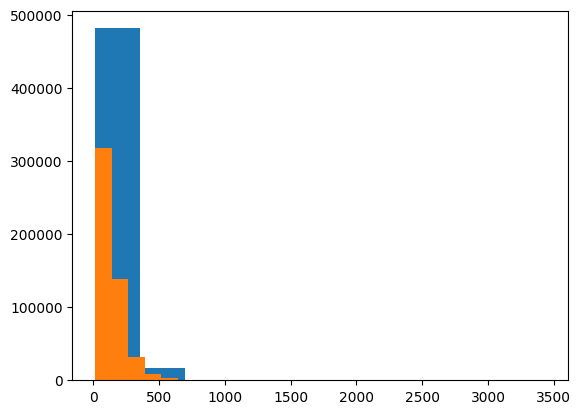

In [115]:
%matplotlib inline

X_lengths = dataset["X"].apply(len)

Y_lengths = dataset["Y"].apply(len)

# Get the frequency distribution of the lengths
plt.hist(X_lengths.values)
plt.hist(Y_lengths.values)

In [8]:
# hugging face dataset for efficient tokenization
hugging_dataset = Dataset.from_pandas(dataset)

def tokenize_function(data):
  return tokenizer(data["X"], text_target = data["Y"], truncation=True, max_length=1024)


tokenized_dataset = hugging_dataset.map(tokenize_function, batched = True)


Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

In [9]:
print(tokenized_dataset)

Dataset({
    features: ['X', 'Y', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 500000
})


In [10]:
tokenized_dataset = tokenized_dataset.remove_columns(["X", "Y"])
tokenized_dataset.set_format("numpy")


In [11]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['test']

In [12]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 450000
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 50000
})


In [13]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 8, collate_fn = data_collator
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = 8, collate_fn = data_collator
)



In [123]:
# for batch in train_dataloader:
#   break

# {k: v.shape for k, v in batch.items()}

In [124]:
# outputs = model(**batch)
# print(outputs.loss)

In [15]:
# distribute training acoss multiple GPUs
model = torch.nn.DataParallel(model)

In [16]:
epochs_to_run = 1
# number of batches to report loss
batch_report_every = 300
optim = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
metric = evaluate.load("google_bleu")

In [32]:
# checkpoint = torch.load("/kaggle/working/checkpoint_epoch_0.pth",  map_location=torch.device('cpu'))

# model.module.load_state_dict(checkpoint["model_state_dict"])
# optim.load_state_dict(checkpoint["optimizer_state_dict"])

# starting_epoch = checkpoint["epoch"] + 1

In [129]:
for state in optim.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
            

In [130]:
# new learning rate
# for param_group in optim.param_groups:
#     param_group["lr"] = 1e-7
    # print(param_group["lr"])
    
    # param_group["lr"] = lr=1e-6

In [131]:
def evaluate_gleu(model, dataloader, metric ,tokenizer, sample_size = 300):
    """
    evaluate the 'metric' on sentences generated by the 'model' 
    using inputs randomly sampled (of total size 'sample_size') from the dataset underlying the 'dataloader'.

    return gleu score averaged across all samples.
    """
    model.eval()
    # sample indices without replacement(no duplicates)
    indices = np.random.choice(range(len(dataloader.dataset)), size=sample_size, replace=False )
    random_dataloader = torch.utils.data.DataLoader(dataloader.dataset, 
                                                    batch_size= dataloader.batch_size,
                                                   sampler = torch.utils.data.SubsetRandomSampler(indices),
                                                   collate_fn = data_collator)
    scores = []
    pad_index = tokenizer.pad_token_id
    with torch.no_grad():
        for batch in random_dataloader:
            
            batch = {k : v.cuda() for k, v in batch.items()}
            
            # get max num of tokens(without padding) among sentences in the batch
            # to determine the max new tokens when generating
            max_new_tokens = max((batch["input_ids"] != pad_index).sum(dim = -1))
            # the number of tokens of the generated sentence should not differ vastly with its input counterpart
            outputs = model.module.generate(**batch, 
                                       max_length= int(max_new_tokens + 10),
                                       num_beams=4,
                                        length_penalty=1.0)

            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            
            batch["labels"][batch["labels"] == -100] = pad_index

            references = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
            # avg score across elements in a batch
            score = metric.compute(predictions=preds, references=references)
            
            scores.append(score["google_bleu"])

    # avg score across batches
    return sum(scores) / len(scores)

    

In [132]:
def evaluate_loss(model, val_dataloader):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for batch in val_dataloader:
      batch = {k : v.cuda() for k, v in batch.items()}

      outputs = model(**batch)

      val_loss += outputs.loss.mean().item()

  val_loss /= len(val_dataloader)
  return val_loss

In [133]:
# used on gleu
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, mode='max', factor=0.3, patience=2)

In [31]:
Epochs = starting_epoch + epochs_to_run
model = model.cuda()

for epoch in range(starting_epoch, Epochs):
  print(f"Epoch: {epoch}")
  model.train()
  avg_batch_loss = 0
  epoch_loss = 0
    
  for i, batch in enumerate(train_dataloader):
    batch = {k : v.cuda() for k, v in batch.items()}

    outputs = model(**batch)

    # loss.mean() because of distributed training
    loss = outputs.loss.mean()
      
    optim.zero_grad()

    loss.backward()
    
    optim.step()
      
    avg_batch_loss += loss.item()
    epoch_loss += loss.item()

    # print avg batch loss
    if not (i + 1) % batch_report_every:
      avg_batch_loss /= batch_report_every
      print(f"-----Batches {i + 1 - batch_report_every} -- {i+1} | Avg Batch Training Loss: {avg_batch_loss}", flush=True)
      avg_batch_loss = 0

    # save after 5,000 batches
    if not (i + 1) % 5000:
        print(f"Saved Model at Batch {i}", flush=True)
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.module.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': loss.item(),
        }, f'checkpoint_epoch_{epoch}_step_{i}.pth')
 
        gleu_score = evaluate_gleu(model, val_dataloader, metric, tokenizer)
        val_loss = evaluate_loss(model, val_dataloader)
        print(f"-----Gleu Score On Validation Data: {gleu_score}", flush=True)
        print(f"-----Val Loss: {val_loss}", flush=True)
        with open("gleu_scores.txt", "a") as file:
            file.write(f"Epoch: {epoch} | Batch: {i} | Gleu Score: {gleu_score} | Val loss: {val_loss}\n")

        scheduler.step(gleu_score)
        
        
  epoch_loss /= len(train_dataloader)
  print(f"-----Training Loss: {epoch_loss}", flush=True)
    
  # save after each epoch
  torch.save({
        'epoch': epoch,
        'model_state_dict': model.module.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': loss.item(),
    }, f'checkpoint_epoch_{epoch}.pth')
    
  val_loss = evaluate_loss(model, val_dataloader)
  
  print(f"-----Validation Loss: {val_loss}", flush=True)
  print("=============================================", flush=True)


Epoch: 0
-----Batches 0 -- 300 | Avg Batch Training Loss: 1.2702706710497538
-----Batches 300 -- 600 | Avg Batch Training Loss: 1.3052358520030976
-----Batches 600 -- 900 | Avg Batch Training Loss: 1.308895122806231
-----Batches 900 -- 1200 | Avg Batch Training Loss: 1.2768433554967245
-----Batches 1200 -- 1500 | Avg Batch Training Loss: 1.2581043761968613
-----Batches 1500 -- 1800 | Avg Batch Training Loss: 1.2324114471673966
-----Batches 1800 -- 2100 | Avg Batch Training Loss: 1.244865139524142
-----Batches 2100 -- 2400 | Avg Batch Training Loss: 1.2197962548335393
-----Batches 2400 -- 2700 | Avg Batch Training Loss: 1.2721824103593826
-----Batches 2700 -- 3000 | Avg Batch Training Loss: 1.289998206694921
-----Batches 3000 -- 3300 | Avg Batch Training Loss: 1.2372516387701034
-----Batches 3300 -- 3600 | Avg Batch Training Loss: 1.2258735315004985
-----Batches 3600 -- 3900 | Avg Batch Training Loss: 1.2207508985201518
-----Batches 3900 -- 4200 | Avg Batch Training Loss: 1.30017908275

In [23]:
def correct_grammar(model, metric, ungrammatical_sen, target =None):
    model.eval()
    google_bleu = None
    
    inputs = tokenizer(ungrammatical_sen, truncation=True, max_length=1024, return_tensors = "pt")

    inputs = {k : v.cuda() for k, v in inputs.items()}

    outputs = model.module.generate(**inputs,
                                    max_length=len(ungrammatical_sen) + 20, 
                                    num_beams=5, 
                                    do_sample=True,
                                   repetition_penalty=2.6,
                                     temperature= 0.01
                                    )

    sentence = tokenizer.decode(outputs[0], skip_special_tokens=True )
    
    # compute gleu score between target and pred
    if target:
        google_bleu = metric.compute(predictions=[sentence], references=[target])
        
    return sentence, google_bleu
    
    
    

In [27]:

# correct_grammar(model, metric,
#                 "Bitcoin is for $7,094 this morning, which CoinDesk says.",
#                target = "Bitcoin goes for $7,094 this morning, according to CoinDesk.")

inp = "fix grammar:My names is ali and i went at school yesterday"

sentence, score = correct_grammar(model, 
                                  metric, 
                                  inp,
                            target = "My name is ali and i went to school yesterday")

print(f"Input: {inp}")
print(f"Output: {sentence}")
if score:
    print(f"Google Bleu: {score['google_bleu'] }")

# correct_grammar(model, metric,
#                 "The effect of widespread dud targets two face up attack position monsters on the field",
#                target = 'The effect of "widespread dud" targets two face up attack position monsters on the field.')
               

# correct_grammar(model, metric,
#                 "tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).",
#                target = "Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law.")

Input: fix grammar:My names is ali and i went at school yesterday
Output: My name is ali and i went to school yesterday.
Google Bleu: 0.8947368421052632
